In [1]:
# Utility Functions
import re
import numpy as np
import torch
torch.manual_seed(42)

def getTextFromFile(file_path = './books/harry_potter.txt', chunkSize=5000 ):
    with open(file_path, 'r') as file:
        book_text = file.read(chunkSize)
    book_text_lower = book_text.lower()
    # text =  re.sub(r'[^a-zA-Z\s]', '', book_text_lower) #re.sub(r'[^\w\s]', '', book_text_lower)
    text = re.sub(r'[^a-zA-Z\s]', '', book_text_lower.replace('\n', ''))
    return text

text = getTextFromFile()

# Create Character Mappings 
chars = sorted(list(set(text)))
n_chars = len(chars)
char_to_index = {ch:i for i,ch in enumerate(chars)}
index_to_char = {i:ch for i,ch in enumerate(chars)}


def one_hot_encode(char):
    vector = np.zeros(n_chars)
    # print(char)
    # print(char_to_index[char])
    vector[char_to_index[char]] = 1
    return vector


def generateTrainingData():
    # Prepare input sequence and corresponding target characters 
    seq_length = 30
    X_data, y_data = [] , []

    for i in range(0,len(text)-seq_length,1):
        seq_in =  text[i:i+seq_length]
        seq_out = text[i+1:i+seq_length+1]
        # print(f"seq_in {seq_in} seq_out {seq_out}")
        X_data.append([one_hot_encode(char) for char in seq_in ])
        y_data.append([one_hot_encode(char) for char in seq_out ])

    # Convert data to pytorch tensors 
    X = torch.tensor(X_data, dtype=torch.float32)
    y = torch.tensor(y_data, dtype=torch.long)  # Change the data type to torch.long

    # print(f" X shape : {X} y shape {y}")
    return X,y

In [2]:
X,y = generateTrainingData()
X.shape , y.shape

/var/folders/27/n5gxzmy10mx08j62x813rw080000gn/T/ipykernel_9980/630702737.py:45: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  X = torch.tensor(X_data, dtype=torch.float32)


(torch.Size([4636, 30, 27]), torch.Size([4636, 30, 27]))

In [3]:
# Model 
import torch 
from torch import nn
torch.manual_seed(42) # For reproducibility
hidden_size = 128

class CharGenerationRNN(nn.Module):
    def __init__(self, n_chars, hidden_size):
        super().__init__()
        self.rnn = nn.RNN(n_chars, hidden_size, num_layers=2)
        self.lin1 = nn.Linear(hidden_size, hidden_size//2)
        self.lin2 = nn.Linear(hidden_size//2, n_chars)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        # Forward pass through the RNN layer.
        output, hidden = self.rnn(x)
        output = self.dropout(output) 
        output = torch.sigmoid(self.lin1(output))
        output = self.dropout(output)
        output = torch.sigmoid(self.lin2(output))


        return output

model = CharGenerationRNN(n_chars,hidden_size)


In [4]:
def sample_size_shape_test():
    input = X[0][0:4]
    # print(f"input {input} shape {input.shape} type {type(input)} ")
    output = model(input)
    print(f"{[ index_to_char[int(torch.argmax(vec))] for vec in input]}")
    print(f"{[ index_to_char[int(torch.argmax(vec))] for vec in output]}")

sample_size_shape_test()

['w', 'h', 'e', 'n']
['w', 'w', 'w', 'w']


In [5]:
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
X.shape , y.shape

(torch.Size([4636, 30, 27]), torch.Size([4636, 30, 27]))

In [6]:
# Testing 
output = model(X)
loss = criteria(output,y.float())
loss

tensor(3.7794, grad_fn=<DivBackward1>)

In [7]:
looses = []

In [26]:

epochs = 500
torch.manual_seed(42) 

for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(X)
    loss = criteria(output,y.float())
    loss.backward()
    optimizer.step()
    looses.append(loss.item())
    print(f"epoch {epoch} loss {loss.item()}")
    sample_size_shape_test()    

epoch 0 loss 3.2037887573242188
['w', 'h', 'e', 'n']
['i', 'e', 'y', ' ']
epoch 1 loss 3.2036054134368896
['w', 'h', 'e', 'n']
['i', 'i', 'y', ' ']
epoch 2 loss 3.203336000442505
['w', 'h', 'e', 'n']
['a', 'i', ' ', ' ']
epoch 3 loss 3.202946186065674
['w', 'h', 'e', 'n']
['a', 'i', ' ', ' ']
epoch 4 loss 3.202622175216675
['w', 'h', 'e', 'n']
['a', 'i', 'y', ' ']
epoch 5 loss 3.2024271488189697
['w', 'h', 'e', 'n']
['a', 'i', ' ', ' ']
epoch 6 loss 3.202319622039795
['w', 'h', 'e', 'n']
['a', 'i', ' ', 'y']
epoch 7 loss 3.201815128326416
['w', 'h', 'e', 'n']
['i', 'i', ' ', ' ']
epoch 8 loss 3.2016172409057617
['w', 'h', 'e', 'n']
['i', 'i', ' ', ' ']
epoch 9 loss 3.2012217044830322
['w', 'h', 'e', 'n']
['a', 'i', ' ', ' ']
epoch 10 loss 3.2009222507476807
['w', 'h', 'e', 'n']
['a', 'i', ' ', ' ']
epoch 11 loss 3.2004587650299072
['w', 'h', 'e', 'n']
['i', 'i', ' ', ' ']
epoch 12 loss 3.2003798484802246
['w', 'h', 'e', 'n']
['i', 'i', ' ', ' ']
epoch 13 loss 3.2002663612365723
['w', '

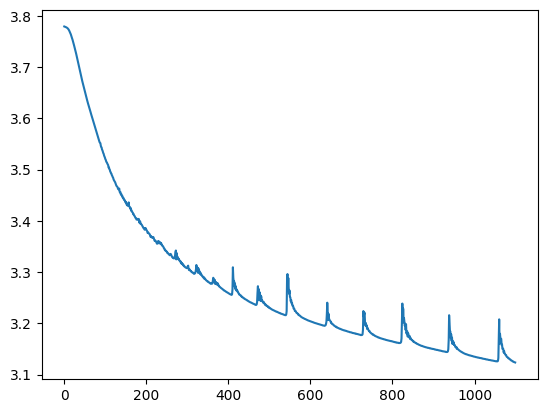

In [27]:
from matplotlib import pyplot as plt
plt.plot(looses)

In [28]:
torch.manual_seed(42) 
from pprint import pprint
def generateNextCharacter(text):
    
    X = []
    for idx,char in enumerate(text):
        X.append(one_hot_encode(char))
    X=torch.tensor(np.array(X),dtype=torch.float32)
    y=model(X)
        # print(y.shape)
        # print(index_to_char[int(torch.argmax(y[-1]))])
    # Assuming y is the target tensor
    top2_indices = torch.topk(y[-1], k=2).indices
    # Randomly choose one index from the top 2
    random_index = torch.randint(0, 2, (1,)).item()
    chosen_index = top2_indices[random_index]
    return index_to_char[int(chosen_index)]
    
def generateN_NextChar(text,n=30):
    for i in range(n):
        nextChar = generateNextCharacter(text)
        text=text+str(nextChar)
        # text = text.replace('\n', ' ')
    # pprint(f"text:{text} len: {len(text)}") 
    pprint(text)   




generateN_NextChar('po',800)

# AFTER 100 EPOCHS
# ('pons nns ansjir tiar bocfanglarsled barddeds zansic insarizledl dirs '
#  'pondessersecficins azjodeslarlid taxnad tisestanliv poxcirls bocaznaxev '
#  'bonslav aasles andes pacarslal sasnedledlisles azborld tovedessanss foxaod '
#  'tacas waves an misl fan caslans worl paslaslad foslaslasles and focided '
#  'wocedlard tor jos ans an tarlll tacislerljedl tarelllessjorl socanslives '
#  'azizcid warisedten izsaxoossjod jad sansladslavl simisassarl cnslandleyles '
#  'parlaslislidled aoslin jos pandedllls cavinl tireslindes azbon micadlans '
#  'fand tirid bocicandinl morlleslevle saan wanlyslad basscans ars ans azjad '
#  'sffzznteeslerlidl tar aod bzanses on jod taar wos mas aus fared aztis '
#  'anslinl bondjad qrizzovand parlel jas wor covlar siriss panselled '
#  'womisastanslas wos barlirds focledleslassandleds bonsjosladlessark mar tor '
#  'tirllll ')

# AFTER 600 EPOCHS
# ('possiryy fovar evarsyyyaxar gcargy ary onyyaxaavin sardyyyanbixivals cashiv '
#  'tod brisgirivareyy or whirg booslas ararlgcirgcany axsy mumosy onyyifavary '
#  'brisgsirnin boxanesgixarx thasysiruyganiraxy poslary ardyamad kivagyavixid '
#  'gfeagdivixiry buxgar bhe pustaxs ons thigisanbar tarx or sucfiny bos an '
#  'barsyansyyaxarisgan bid cavid qvand chixory pocbid wavagisegtervixted bus '
#  'toixiol kaxkanygoxrary tneix bn tnsixixyyycpocbixyivad gnaulg buxardysixlil '
#  'cuxdaassaxixy bxyyytandy whigidavinissarrarsasaley mngalixsixv pucty on jus '
#  'bravavisyy fourgyyiraxcivikig inyixaakyyaxfar costiry mucpictix ir tovare '
#  'wos buy britasavir grixhirs toakey hassaxidy buctirled arsivir tady '
#  'bhixgyivav bar tor gus cos aryyinaksyybaacnyixr sucastexixass bndey '
#  'boxivavixyyy bnstauxions mocax yuslx an bar toreyyyibryyavaxixsyy cu')

# AFTER 1100 EPOCHS
# ('pomsiryy fobong paxixgy jnsjusd ofinticistearimedy '
#  'mocheyyerisbirytarorisisbaxyindy pfinithex arstbuas hig faxey xn '
#  'oxaxisirryyyany bopecbiusyyaxareysbntid sharv boods ous oxinvin wos '
#  'thiclyysobuosyarixs arjy wug caxusy bop arimedyyaxares br an finyy '
#  'wumhergixareggafgifesy pimoxsy bovivirg ban bobimisixusyyqfin  '
#  'caxreegoxxsaxyyy andixhixyy ffon onyy himovaxoryygazoug '
#  'ouxaxyyygonbwegyyixaxd cuttoux arygbcerbqixeid gvaresy hixid sping bar '
#  'tobidyyifed ausdy homhe mos werisoxyeos bxiuxyy pfhardgyy ppipuvg buontin '
#  'quaxxes bngcixbiryy pucferyys puppissavexyy bofibestixixey bftaol ar  fofgg '
#  'ifdestoregificavtivadisis an jucb aninaxy br bcarder jxsyy wumg '
#  'hecpegtanhisocgeimaxiryy ongire com guxigeek fofbex wolgguixoig cinhixiy '
#  'arescanghirs toisyilixmimy on he cominx ax buctemoxidystoos axaxissixex yn')

('pomsiryy fobong paxixgy jnsjusd ofinticistearimedy '
 'mocheyyerisbirytarorisisbaxyindy pfinithex arstbuas hig faxey xn '
 'oxaxisirryyyany bopecbiusyyaxareysbntid sharv boods ous oxinvin wos '
 'thiclyysobuosyarixs arjy wug caxusy bop arimedyyaxares br an finyy '
 'wumhergixareggafgifesy pimoxsy bovivirg ban bobimisixusyyqfin  '
 'caxreegoxxsaxyyy andixhixyy ffon onyy himovaxoryygazoug '
 'ouxaxyyygonbwegyyixaxd cuttoux arygbcerbqixeid gvaresy hixid sping bar '
 'tobidyyifed ausdy homhe mos werisoxyeos bxiuxyy pfhardgyy ppipuvg buontin '
 'quaxxes bngcixbiryy pucferyys puppissavexyy bofibestixixey bftaol ar  fofgg '
 'ifdestoregificavtivadisis an jucb aninaxy br bcarder jxsyy wumg '
 'hecpegtanhisocgeimaxiryy ongire com guxigeek fofbex wolgguixoig cinhixiy '
 'arescanghirs toisyilixmimy on he cominx ax buctemoxidystoos axaxissixex yn')
